# Synthetic Skull Filtering w/ Normalized MSE 

1. We first trim the data to get rid of the large blank space in the lower half of the skulls.   
2. Second, we define a function, MSE_norm(a,b), that ravels matrices a and b, computes the global maximum of the two, normalizes each vector accordingly, and then computes the MSE between them. The normalization is done so that we have a sense for what threshold value we want to use for the filtering process. 
3. Then, we compute this normalized MSE between all pairs of skulls and remove those that are too similar based on some predefined threshold. To do this, we run two for loops over the skulls, and keep track of skull indices that were too similar so that in the end we remove them. (A dynamic approach where indices were removed on the spot became too complicated, as we had to account for the index shift of the outside for loop everytime an index was removed.)

## Imports

In [4]:
import random
import numpy as np 
import matplotlib.pyplot as plt

# high-res figures
%config InlineBackend.figure_format = 'retina'

## Load Data



In [7]:
# load the raw skulls
data_raw = np.load('/Users/karanps/Library/CloudStorage/GoogleDrive-karanps@stanford.edu/My Drive/Past Research/KBP Lab/ML/TUSNet/other/shards/fake_skulls.npy')

In [10]:
# trim the data and remove the bottom blank portion
data_trimmed = []
for i in range(len(data_raw)):
    data_trimmed.append(data_raw[i][:50, :])

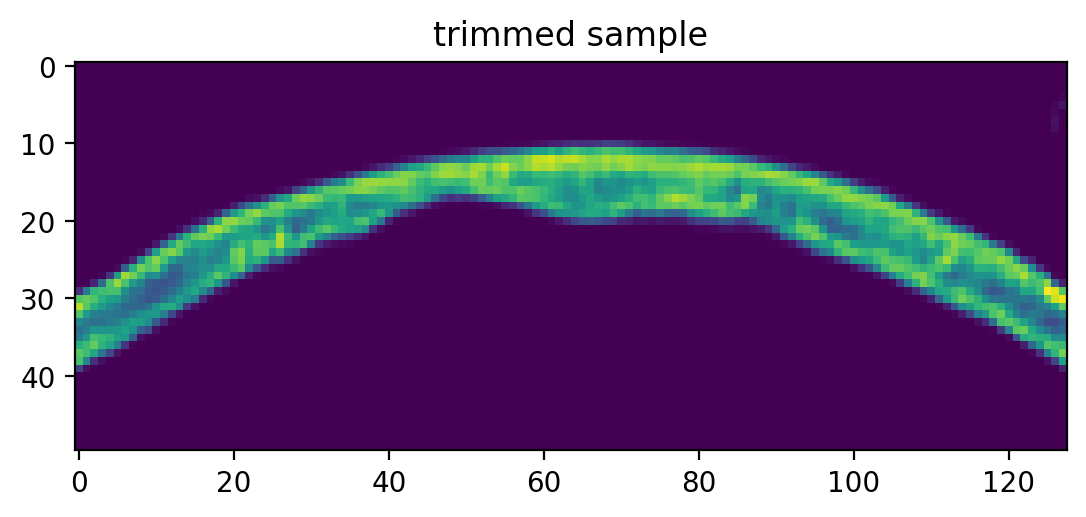

In [11]:
# example plot
plt.title('trimmed sample')
plt.imshow(data_trimmed[100])
plt.show()

## Similarity Measure

In [12]:
def MSE_norm(a, b):
    # ravel and binarize the first matrix
    vec1 = np.copy(a)
    vec1 = np.ravel(vec1)
    vec1[vec1 <= 1200] = 0
    vec1[vec1 > 1200] = 1

    # ravel and binarize the second matrix    
    vec2 = np.copy(b)
    vec2 = np.ravel(vec2)
    vec2[vec2 <= 1200] = 0
    vec2[vec2 > 1200] = 1
    
    # compute the difference vector
    diff = (vec1 - vec2)
    
    # compute the MSE over the normalized vectors 
    return np.mean(diff.T @ diff)

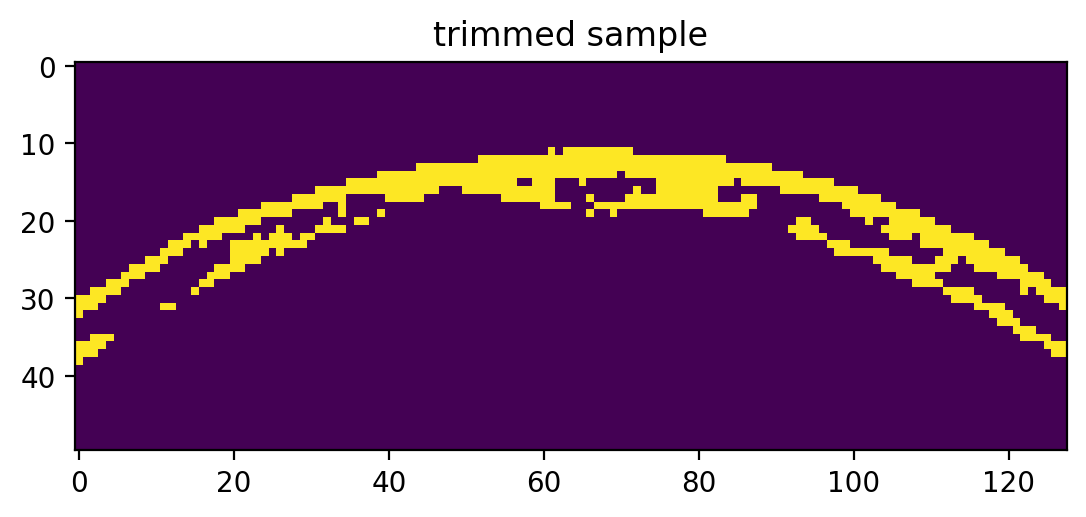

In [13]:
ex = np.copy(data_trimmed[100])
ex[ex <= 1200] = 0
ex[ex >= 1200] = 1

plt.title('trimmed sample')
plt.imshow(ex)
plt.show()

## Visual Selection of an Appropriate MSE Threshold

In [31]:
def plot_similar_skulls(skull_idx, cutoff = 200):
    # preliminaries
    MSE_list = []

    # compute distance between chosen skull and every other skull
    for i in range(5000):
        MSE_list.append(MSE_norm(data_trimmed[skull_idx], data_trimmed[i]))

    # convert to NumPy array
    MSE_list = np.asarray(MSE_list)
    
    # plot all similar skulls
    plt.figure(figsize=(20, 10))
    for i, j in enumerate(np.where(MSE_list < cutoff)[0]):
        plt.subplot(5, 8, i+1)
        plt.imshow(data_trimmed[j])
        plt.xlabel(str(MSE_list[j]))    
        plt.title('reference' if j == skull_idx else 'skull ' + str(j))
    plt.tight_layout()
    plt.show()

    similar_skulls = np.where(np.asarray(MSE_list) < cutoff)[0] 
    print(f"Skull {skull_idx}: {len(similar_skulls)} similar skulls")

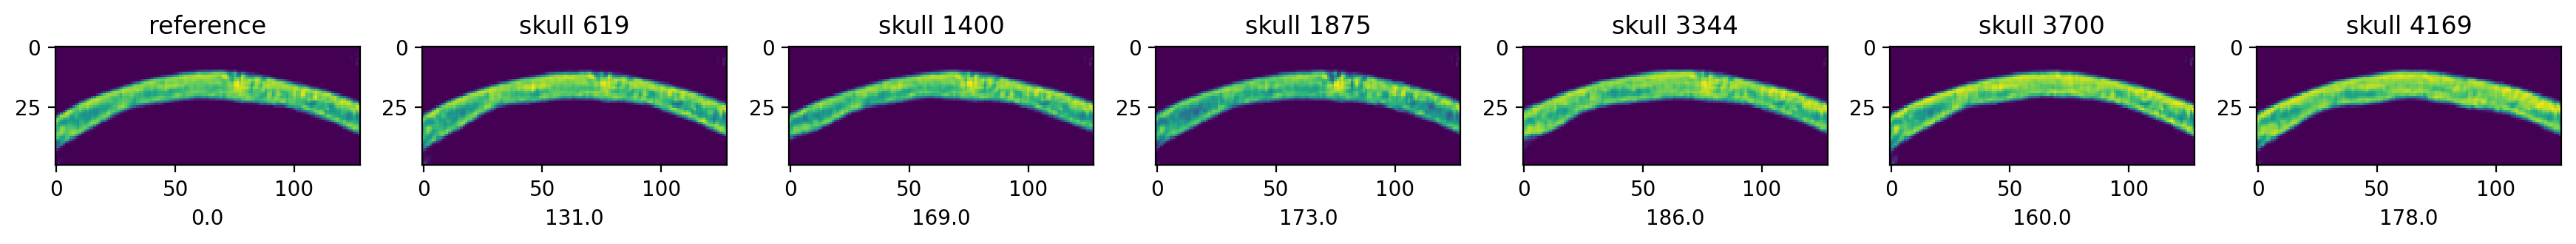

Skull 10: 7 similar skulls


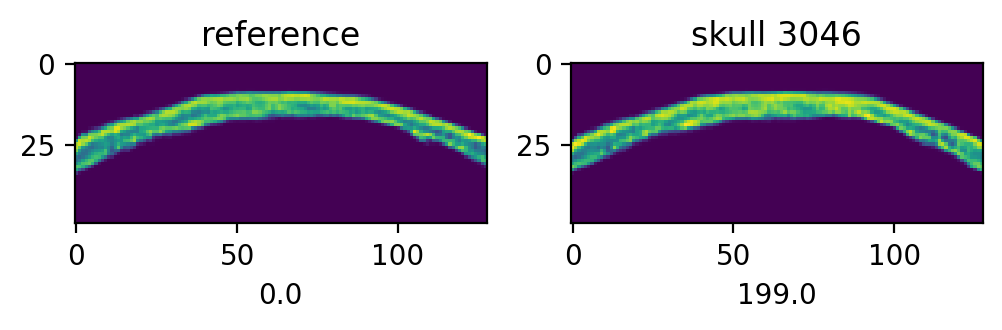

Skull 770: 2 similar skulls


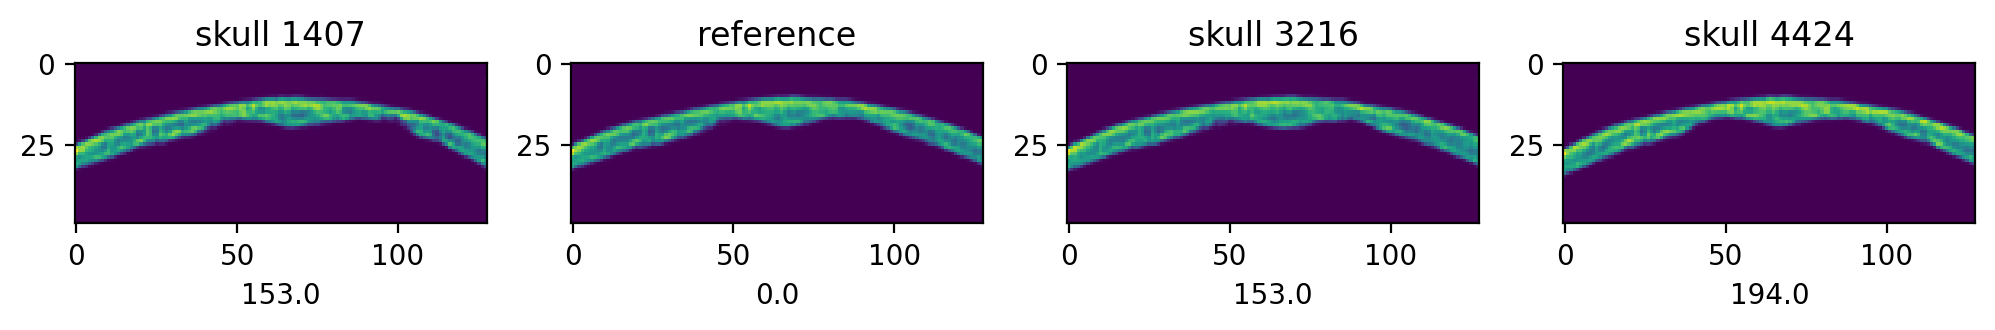

Skull 2500: 4 similar skulls


In [32]:
# choose a selection threshold
selection_cutoff = 200

# visualize the resulting similar skulls
plot_similar_skulls(10, selection_cutoff)
plot_similar_skulls(770, selection_cutoff)
plot_similar_skulls(2500, selection_cutoff)

## Actual Sorting [~5 min]

In [36]:
skip = []

for i in range(5000):
    if i in skip:
        continue
    for j in range(5000):
        if j > i and MSE_norm(data_trimmed[i], data_trimmed[j]) < selection_cutoff:
            # skip contains the indices that we don't want
            skip.append(j)
    if i % 10 == 0: 
        print(i, "/ 5000 done!", end="\r")

print("We need to remove", len(set(skip)), "samples indicated in the 'skip' list")
np.save("skip_indices", list(set(skip)))